In [5]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.autograd import grad
import torchvision
from typing import Any, Callable, List, Optional, Type, Union, Tuple

from torch import Tensor
from torchvision import models, datasets, transforms
from collections import OrderedDict, namedtuple
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)


1.12.1+cu113 0.13.1+cu113


In [7]:
dataset = datasets.CIFAR100("~/.torch", download=True)
transform_operation = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def reverse_transform(image):
    """ reverse the normalized image back to JPG format """
    output = ((image.detach().cpu().numpy().transpose(1, 2, 0)*np.array([[[0.229, 0.224, 0.225]]]) + np.array([[[0.485, 0.456, 0.406]]]))*255)
    output[output > 255] = 255
    output[output < 0] = 0
    output = output.astype(np.uint8)
    return output

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


loss = torch.nn.CrossEntropyLoss()

Files already downloaded and verified


In [56]:
InceptionOutputs = namedtuple("InceptionOutputs", ["logits", "aux_logits"])
InceptionOutputs.__annotations__ = {"logits": Tensor, "aux_logits": Optional[Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _InceptionOutputs set here for backwards compat
_InceptionOutputs = InceptionOutputs


class Inception3(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        aux_logits: bool = True,
        transform_input: bool = False,
        inception_blocks: Optional[List[Callable[..., nn.Module]]] = None,
        init_weights: Optional[bool] = None,
        dropout: float = 0.5,
    ) -> None:
        super().__init__()

        if inception_blocks is None:
            inception_blocks = [BasicConv2d, InceptionA, InceptionB, InceptionC, InceptionD, InceptionE, InceptionAux]

        if len(inception_blocks) != 7:
            raise ValueError(f"lenght of inception_blocks should be 7 instead of {len(inception_blocks)}")
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        self.AuxLogits: Optional[nn.Module] = None
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2048, num_classes)
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    stddev = float(m.stddev) if hasattr(m, "stddev") else 0.1  # type: ignore
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=stddev, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[Tensor] = None
        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux: Optional[Tensor]) -> InceptionOutputs:
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x  # type: ignore[return-value]

    def forward(self, x: Tensor) -> InceptionOutputs:
        x = self._transform_input(x)
        x, aux = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                pass
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)


class InceptionA(nn.Module):
    def __init__(
        self, in_channels: int, pool_features: int, conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):
    def __init__(self, in_channels: int, conv_block: Optional[Callable[..., nn.Module]] = None) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):
    def __init__(
        self, in_channels: int, channels_7x7: int, conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):
    def __init__(self, in_channels: int, conv_block: Optional[Callable[..., nn.Module]] = None) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):
    def __init__(self, in_channels: int, conv_block: Optional[Callable[..., nn.Module]] = None) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(
        self, in_channels: int, num_classes: int, conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001  # type: ignore[assignment]

    def forward(self, x: Tensor) -> Tensor:
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.sigmoid(x)


def inception_v3(*, weights= None, progress: bool = True, **kwargs: Any) -> Inception3:
    """
    Inception v3 model architecture from
    `Rethinking the Inception Architecture for Computer Vision <http://arxiv.org/abs/1512.00567>`_.
    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.
    Args:
        weights (:class:`~torchvision.models.Inception_V3_Weights`, optional): The
            pretrained weights for the model. See
            :class:`~torchvision.models.Inception_V3_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.Inception3``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py>`_
            for more details about this class.
    .. autoclass:: torchvision.models.Inception_V3_Weights
        :members:
    """
    model = Inception3(**kwargs)

    return model 
inceptionnet = inception_v3(num_classes=100).to(device)


## Honest participants
This is the image used by the honest trainer, where only the gradients will be shared to other trainers (under the name original_derivatives)

In [88]:
dataset[25]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F54319745D0>, 84)

In [92]:
torch.concat(ground_truth_data, axis=0).shape

torch.Size([2, 3, 299, 299])

In [97]:
example_index = [25, 26]
ground_truth_data = torch.concat([transform_operation(dataset[example_index[i]][0]).to(device).unsqueeze(0) for i in range(2)], axis=0)
ground_truth_label = torch.Tensor([dataset[i][1] for i in example_index]).to(device).long()
ground_truth_label = torch.nn.functional.one_hot(ground_truth_label, num_classes=100)
inceptionnet.train()
model_prediction = inceptionnet(ground_truth_data)

predicted_loss = loss(model_prediction.logits, ground_truth_label.float())

derivatives = torch.autograd.grad(predicted_loss, inceptionnet.parameters(), allow_unused=True)

original_derivatives = [layer_derivative.detach().clone() if layer_derivative is not None else None for layer_derivative in derivatives ]

Plot the ground truth image

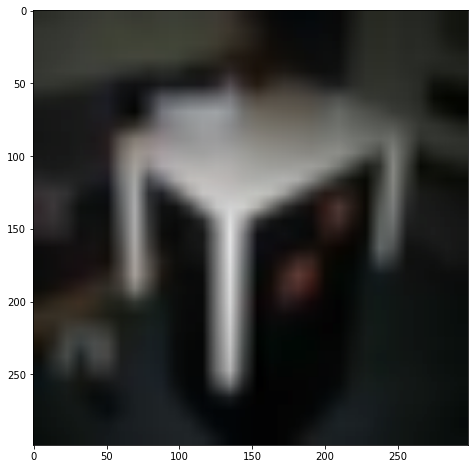

In [98]:
ground_truth_jpg = reverse_transform(ground_truth_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(ground_truth_jpg)

## Generate dummy data and dummy label
Here, we will generate an image using random pixel and random label

Dummy label is 95.


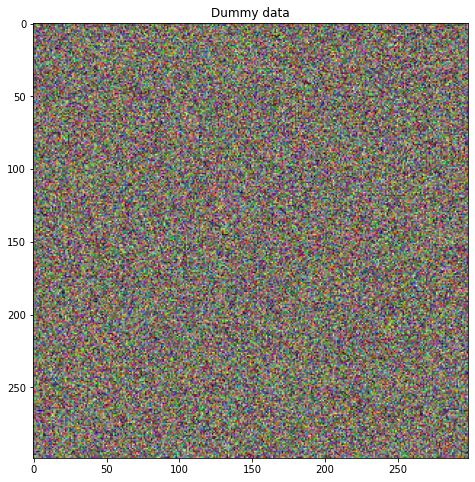

In [118]:
dummy_data = torch.randn(ground_truth_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(ground_truth_label.size()).to(device).requires_grad_(True)

dummy_data_jpg = reverse_transform(dummy_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(dummy_data_jpg)
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label[0], dim=-1).item())

In [119]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=0.1)

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = inceptionnet(dummy_data) 
        dummy_onehot_label = torch.nn.functional.softmax(dummy_label, dim=-1)
        dummy_loss = loss(pred.logits, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, inceptionnet.parameters(), create_graph=True, allow_unused=True)

        grad_diff = 0
        grad_count = 0

        for gx, gy in zip(dummy_dy_dx, original_derivatives):
            if gx is None or gy is None:
                continue
            grad_diff += ((gx - gy)**2).sum()
            grad_count += gx.nelement()
        #grad_diff = grad_diff / grad_count
        grad_diff.backward()
        return grad_diff
    
    optimizer.step(closure)
    if iters % 1 == 0: 
        current_loss = closure()
        print(iters, datetime.now().isoformat(), "%.10f" % current_loss.item())
    history.append(reverse_transform(dummy_data[0]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 2022-09-01T05:53:57.827616 422.1846313477
1 2022-09-01T05:54:02.676408 394.8950500488
2 2022-09-01T05:54:07.550839 393.5885620117
3 2022-09-01T05:54:12.468884 389.8407897949
4 2022-09-01T05:54:17.414080 395.4187011719
5 2022-09-01T05:54:22.406189 390.6367187500
6 2022-09-01T05:54:27.391679 850.2446899414
7 2022-09-01T05:54:32.406464 831.4796142578
8 2022-09-01T05:54:37.429457 827.1931762695
9 2022-09-01T05:54:42.466333 802.3909301758
10 2022-09-01T05:54:47.736679 810.7192382812
11 2022-09-01T05:54:52.768466 801.1986083984
12 2022-09-01T05:54:57.805855 795.0692749023
13 2022-09-01T05:55:02.854548 793.0855712891
14 2022-09-01T05:55:07.895896 807.5010375977
15 2022-09-01T05:55:12.916310 817.6790771484
16 2022-09-01T05:55:17.950439 808.7221679688
17 2022-09-01T05:55:22.984745 798.7091064453
18 2022-09-01T05:55:28.015958 807.9580688477
19 2022-09-01T05:55:33.028802 780.5076293945
20 2022-09-01T05:55:38.049917 1090.0556640625
21 2022-09-01T05:55:43.067926 1074.1435546875
22 2022-09-01T05:5

# Plot the evolution of the image

Dummy label is 64.


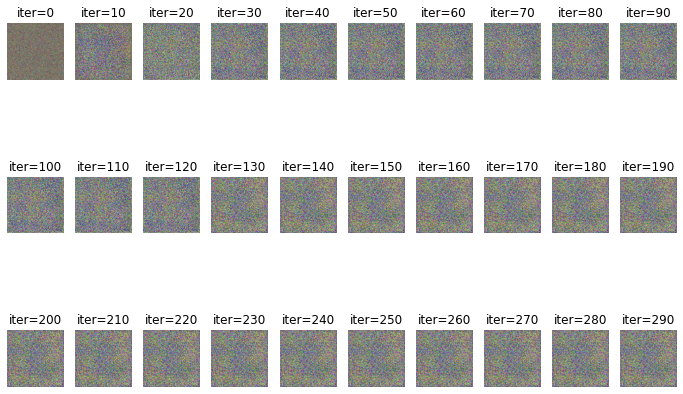

In [120]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i*10])
  plt.title("iter=%d" % (i*10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label[0], dim=-1).item())

# Plot the final output

Text(0.5, 1.0, 'Dummy data')

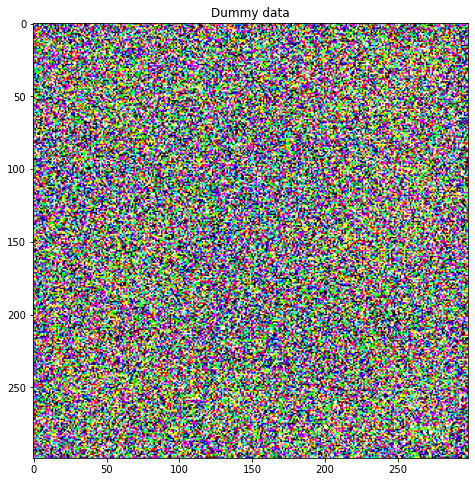

In [121]:
plt.figure(figsize=(8, 8))
plt.imshow(history[-1])
plt.title("Dummy data")

# Plot MSE vs steps

Text(0.5, 1.0, 'MSE vs step of Lenet')

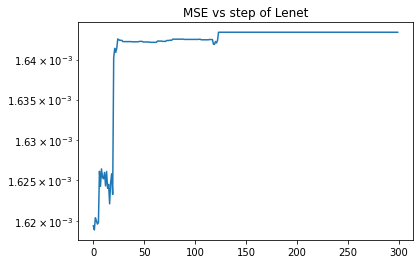

In [122]:
mse_array = [
    np.mean((ground_truth_jpg - history[i])**2)/255**2  for i in range(len(history))
]

plt.semilogy(np.arange(len(history)), mse_array)
plt.title("MSE vs step of Lenet")

In [117]:
print(mse_array)

[0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.0016434865954930078, 0.00164348

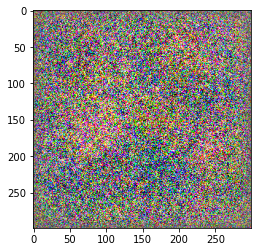

In [111]:
plt.imshow(reverse_transform(dummy_data[1]))